In [42]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img
import os
import random
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw, ImageEnhance
from keras_segmentation.predict import model_from_checkpoint_path
from matplotlib import image as im


# Setting up base network

### Preprocessing

In [43]:
# Controls
train_with_meta_filters = False
train_with_bounding_boxes = False
train_with_segmentation_masks = False

# bb_model = load_model(bounding_box_augmentor_path)
# model = model_from_checkpoint_path(seg_mask_augmentor_path)

def preprocessing(image):
    # print("Before:")
    # print(np.shape(image))
    # plt.imshow(array_to_img(image)) 
    # plt.show()

    if (train_with_bounding_boxes):



        # bb_model = load_model(bounding_box_augmentor_path)
        image = image / 255.0
        image = np.expand_dims(image, axis=0)

        preds = bb_model.predict(image)[0]
        (startX, startY, endX, endY) = preds
        # scale the predicted bounding box coordinates based on the image
        # dimensions
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
       
        # image = tensor_to_image(image)

        # draw = ImageDraw.Draw(image) 
        # draw.rectangle([startX, startY, endX, endY], outline ="green")

        # plt.imshow(image[0]) 
        # plt.show()

        image = img_to_array(image[0])
        # return image

    if (train_with_segmentation_masks):


        out = model.predict_segmentation(
        # inp= path + "/" + i,
        # checkpoints_path =checkpoint_path,
        inp=image,
        out_fname= seg_mask_temp_path,
        overlay_img=True
        )

        image = im.imread(seg_mask_temp_path)

        # plt.imshow(image) 
        # plt.show()

    if (train_with_bounding_boxes):
        image = array_to_img(image)

        draw = ImageDraw.Draw(image)
        draw.rectangle([startX, startY, endX, endY], outline ="green")
        # plt.imshow(image) 
        # plt.show()

        image = img_to_array(image)
    
    if(train_with_meta_filters):
        

        image = array_to_img(image)
        # plt.imshow(image) 
        # plt.show()

        enhancer = ImageEnhance.Contrast(image)
        # rand = random.randint(0,9)
        # if (rand % 2 == 0):
        image = enhancer.enhance(3)
        # rand = random.randint(0,9)
        # if (rand % 2 == 0):
        #     image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        # rand = random.randint(0,9)
        # if (rand % 2 == 0):
        frac = 0.9
        left = image.size[0]*((1-frac)/2)
        upper = image.size[1]*((1-frac)/2)
        right = image.size[0]-((1-frac)/2)*image.size[0]
        bottom = image.size[1]-((1-frac)/2)*image.size[1]
        image = image.crop((left, upper, right, bottom))
        image = image.resize((224,224))
    
        image = img_to_array(image)

    # print("After:")
    # plt.imshow(array_to_img(image)) 
    # plt.show()
    return image

### Create base model

In [44]:
batch_size = 10

def create_base_network(in_dims):
    """
    Base network that takes the inital input and begins learning.
    """
    model = tf.keras.Sequential(name="base_model")
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=in_dims))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(1,1))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    # model.add(tf.keras.layers.MaxPooling2D(2,2))
    # model.add(ResidualBlock(64).forward(input=()))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    

    return model

model = create_base_network((224,224,3))
print(model.summary())

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      9280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 26, 26, 64)       0

### Train the base model

In [45]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing)
train_generator = train_datagen.flow_from_directory(
    # 'E:/Data/Base Network Training/Unaltered',
    './base network training',
    target_size=(224,224),
    batch_size=batch_size,
    classes=['Erosions','Erythemas','Normal','Polyps','Ulcers'],
    class_mode='categorical',
    )

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=['accuracy'])

total_sample = train_generator.n
# print(train_generator[0])
n_epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=int(total_sample/batch_size),
    epochs=n_epochs,
    verbose=1)

Found 1974 images belonging to 5 classes.
Epoch 1/10
197/197 [==============================] - 33s 163ms/step - loss: 1.0385 - accuracy: 0.6512
Epoch 2/10
197/197 [==============================] - 32s 162ms/step - loss: 0.6918 - accuracy: 0.7495
Epoch 3/10
197/197 [==============================] - 32s 161ms/step - loss: 0.5230 - accuracy: 0.8075
Epoch 4/10
197/197 [==============================] - 32s 161ms/step - loss: 0.4950 - accuracy: 0.8172
Epoch 5/10
197/197 [==============================] - 32s 160ms/step - loss: 0.4361 - accuracy: 0.8467
Epoch 6/10
197/197 [==============================] - 32s 160ms/step - loss: 0.3922 - accuracy: 0.8549
Epoch 7/10
197/197 [==============================] - 31s 160ms/step - loss: 0.3352 - accuracy: 0.8758
Epoch 8/10
197/197 [==============================] - 31s 160ms/step - loss: 0.3292 - accuracy: 0.8758
Epoch 9/10
197/197 [==============================] - 31s 159ms/step - loss: 0.2736 - accuracy: 0.9027
Epoch 10/10
197/197 [==========

# Setting up the Siamese neural network

### Preprocessing

In [46]:
bounding_box_augmentor_path = "E:/Code/Final_SNN/bounding_box_augmentations/output/erosions_erythemas_polyps_ulcers_detector.h5"
bb_temp_path = "E:/Code/Final_SNN/bb_temp.jpg"
seg_mask_augmentor_path = "E:/Data/Annotated Images/Polyps/Checkpoints"

seg_mask_temp_path = "E:/Code/Final_SNN/temp2.jpg"

bb_model = load_model(bounding_box_augmentor_path)
seg_model = model_from_checkpoint_path(seg_mask_augmentor_path)


def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224,224))
    image = image.numpy()
    # print(image.numpy().shape)
    # image = tf.expand_dims(image, 0)

    if (train_with_bounding_boxes):

        # image = image / 255.0
        image = np.expand_dims(image, axis=0)

        # print("Image before bb")
        # plt.imshow(image[0]) 
        # plt.show()

        preds = bb_model.predict(image)[0]
        (startX, startY, endX, endY) = preds
        # scale the predicted bounding box coordinates based on the image
        # dimensions
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
       
        # image = tensor_to_image(image)

        # draw = ImageDraw.Draw(image) 
        # draw.rectangle([startX, startY, endX, endY], outline ="green")
        # print("Image after bb")
        # plt.imshow(image[0]) 
        # plt.show()

        image = img_to_array(image[0])

        # return image

    if (train_with_segmentation_masks):

        image = np.expand_dims(image, axis=0)
        image = array_to_img(image[0])
        # print("Image before seg mask")
        # plt.imshow(image) 
        # plt.show()
        image = img_to_array(image)

        out = seg_model.predict_segmentation(
        # inp= path + "/" + i,
        # checkpoints_path =checkpoint_path,
        inp=image,
        out_fname= seg_mask_temp_path,
        overlay_img=True
        )

        image = im.imread(seg_mask_temp_path)

        # print("Image after seg mask")
        # plt.imshow(image) 
        # plt.show()

    if (train_with_bounding_boxes):
        image = array_to_img(image)

        draw = ImageDraw.Draw(image)
        draw.rectangle([startX, startY, endX, endY], outline ="green")
        # plt.imshow(image) 
        # plt.show()

        image = img_to_array(image)
    
    if(train_with_meta_filters):
        
        # print("Meta filter image before")
        image = array_to_img(image)
        # plt.imshow(image) 
        # plt.show()

        enhancer = ImageEnhance.Contrast(image)
        # rand = random.randint(0,9)
        # if (rand % 2 == 0):
        image = enhancer.enhance(3)
        # rand = random.randint(0,9)
        # if (rand % 2 == 0):
        #     image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        # rand = random.randint(0,9)
        # if (rand % 2 == 0):
        frac = 0.9
        left = image.size[0]*((1-frac)/2)
        upper = image.size[1]*((1-frac)/2)
        right = image.size[0]-((1-frac)/2)*image.size[0]
        bottom = image.size[1]-((1-frac)/2)*image.size[1]
        image = image.crop((left, upper, right, bottom))
        image = image.resize((224,224))
    
        # image = img_to_array(image)

        # print("Meta filter image after:")
        # plt.imshow(image) 
        # plt.show()
        # # print(image)
        image = img_to_array(image)
        # image = tf.io.decode_image(image, channels=3, dtype=tf.dtypes.float32)
        # image = tf.convert_to_tensor(image)

    
    image = tf.expand_dims(image, 0)
    return image#.numpy()

def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

def getTrainingAndTestingDatasets(batch_size, training_testing_split, findings_folder_path, normal_folder_path):
    findings_filenames = []
    normal_filenames = []
    
    for filename in  os.listdir(findings_folder_path):
        f = os.path.join(findings_folder_path, filename)
        findings_filenames.append(f)

    for filename in  os.listdir(normal_folder_path):
        f = os.path.join(normal_folder_path, filename)
        normal_filenames.append(f)

    findings_size = np.shape(findings_filenames)
    normal_size = np.shape(normal_filenames)

    print("\nFindings image size: " + str(np.shape(findings_filenames)))
    print("Normal image size: " + str(np.shape(normal_filenames)) + "\n")

    train_data = []
    test_data = []

    for x in range(batch_size):
        # Every second triplet, the anchor is normal
        # if(x < batch_size*training_testing_split):
        if (x%2 == 0):
            anchor_file = findings_filenames[random.randrange(int(findings_size[0]))]
            positive_file = findings_filenames[random.randrange(int(findings_size[0]))]
            negative_file = normal_filenames[random.randrange(int(normal_size[0]))]
        else:
            anchor_file = normal_filenames[random.randrange(int(normal_size[0]))]
            positive_file = normal_filenames[random.randrange(int(normal_size[0]))]
            negative_file = findings_filenames[random.randrange(int(findings_size[0]))]

        triplet = preprocess_triplets(anchor_file, positive_file, negative_file)
        train_data.append(triplet)
        # else:
    for x in range(200):
        if (x%2 == 0):
            anchor_file = findings_filenames[random.randrange(int(findings_size[0]))]
            positive_file = findings_filenames[random.randrange(int(findings_size[0]))]
            negative_file = normal_filenames[random.randrange(int(normal_size[0]))]
        else:
            anchor_file = normal_filenames[random.randrange(int(normal_size[0]))]
            positive_file = normal_filenames[random.randrange(int(normal_size[0]))]
            negative_file = findings_filenames[random.randrange(int(findings_size[0]))]

        triplet = preprocess_triplets(anchor_file, positive_file, negative_file)
        test_data.append(triplet)


    print("Training data size: ", len(train_data))
    print("Testing data size: ", len(test_data))

    return train_data, test_data

def tensor_to_image(tensor):
    if(not train_with_meta_filters and
       not train_with_bounding_boxes and 
       not train_with_segmentation_masks):
        tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def visualize(triplet):
    anchor = triplet[0]
    positive = triplet[1]
    negative = triplet[2]

    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    
    plt.sca(axs[0])
    plt.imshow(tensor_to_image(anchor))
    plt.title('Anchor')
    plt.sca(axs[1])
    plt.imshow(tensor_to_image(positive))
    plt.title('Positive')
    plt.sca(axs[2])
    plt.imshow(tensor_to_image(negative))
    plt.title('Negative')

    #plt.tight_layout()
    plt.suptitle('Triplet Visualization')
    plt.show()

    # plt.imshow(tensor_to_image(anchor))
    # plt.show()
    # plt.imshow(tensor_to_image(positive))
    # plt.show()
    # plt.imshow(tensor_to_image(negative))
    # plt.show()

True
loaded weights  E:\Data\Annotated Images\Polyps\Checkpoints.4


### Training and testing functions

In [47]:
def trainSnn(model, epoch_num, train_data):
    y_dummie = np.ndarray([1,1,1])

    for epoch in range(epoch_num):
        print("epoch: " + str(epoch + 1))
        for triplet in train_data:
            model.fit(x=triplet, y=y_dummie)

    return model

def testSnn(model, test_data):
    correct_preds = 0
    for i in range(len(test_data)):
        encodings = model.predict(test_data[i])
        anchor = tf.convert_to_tensor(encodings[0])
        positive = tf.convert_to_tensor(encodings[1]) 
        negative = tf.convert_to_tensor(encodings[2])
        
        cosine_similarity = tf.metrics.CosineSimilarity()

        positive_similarity = cosine_similarity(anchor, positive)
        print("Positive similarity:", positive_similarity.numpy())

        cosine_similarity = tf.metrics.CosineSimilarity()

        negative_similarity = cosine_similarity(anchor, negative)
        print("Negative similarity", negative_similarity.numpy())

        if (positive_similarity.numpy() > negative_similarity.numpy()):
            correct_preds = correct_preds + 1
            print("Correct prediction!")

    print("Correct predications:", correct_preds)
    print("Accuracy", (correct_preds/len(test_data))*100,'%')

    return (correct_preds/len(test_data))*100

### Create SNN from base network

In [48]:
def lossless_triplet_loss(y_true, y_pred, N = 3, beta=3, epsilon=1e-8, margin=0.2):

    anchor = tf.convert_to_tensor(y_pred[:,0])
    positive = tf.convert_to_tensor(y_pred[:,1]) 
    negative = tf.convert_to_tensor(y_pred[:,2])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),-1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),-1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    # pos_dist = -tf.math.log(-tf.divide((pos_dist),beta)+1+epsilon)
    # neg_dist = -tf.math.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss

    loss = pos_dist - neg_dist + margin
    loss = tf.maximum(loss,0.0)
    
    return loss

def createSNN():

    embedding = tf.keras.Model(inputs=model.input, outputs=model.layers[-4].output)
    # print(embedding.summary())

    anchor_in = tf.keras.Input(shape=(224,224,3))
    pos_in = tf.keras.Input(shape=(224,224,3))
    neg_in = tf.keras.Input(shape=(224,224,3))

    anchor_out = embedding(anchor_in)
    anchor_out = tf.keras.layers.BatchNormalization()(anchor_out)


    pos_out = embedding(pos_in)
    pos_out = tf.keras.layers.BatchNormalization()(pos_out)
    

    neg_out = embedding(neg_in)
    neg_out = tf.keras.layers.BatchNormalization()(neg_out)


    snnModel = tf.keras.Model(inputs=(anchor_in, pos_in, neg_in), outputs=(anchor_out,pos_out,neg_out))
    snnModel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=lossless_triplet_loss)
   
    return snnModel

snnModel = createSNN()
print(snnModel.summary())

Model: "model_411"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_606 (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_607 (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_608 (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                        

# Train and run some tests!

## Training and Testing functions

In [49]:
num_of_tests = 10
training_testing_split = 0.8

normal_folder_path = "E:/Data/TrainingAndTesting/NoFindings/Unaltered"
ulcer_folder_path = "E:/Data/TrainingAndTesting/Ulcers/Unaltered"
polyp_folder_path = "E:/Data/TrainingAndTesting/Polyps/Unaltered"
erythema_folder_path = "E:/Data/TrainingAndTesting/Erythemas/Unaltered"
erosion_folder_path = "E:/Data/TrainingAndTesting/Erosions/Unaltered"



### Ulcers
def runUlcerTests():
    history = []
    train_data, test_data = getTrainingAndTestingDatasets(batch_size, training_testing_split, ulcer_folder_path, normal_folder_path)
    for i in range(num_of_tests):
        snnModel = createSNN()
        snnModel = trainSnn(snnModel, 1, train_data)
        accuracy = testSnn(snnModel, test_data)
        history.append(accuracy)
    print('RESULTS:')
    print("Ulcers detection test accuracies: " + ", ".join(str(a) for a in history) + "\n" )
    print("Average accuracy: "+ str(sum(history)/len(history)) + "\n" )

### Polyps
def runPolypTests():
    history = []
    train_data, test_data = getTrainingAndTestingDatasets(batch_size, training_testing_split, polyp_folder_path, normal_folder_path)
    for i in range(num_of_tests):
        snnModel = createSNN()
        snnModel = trainSnn(snnModel, 1, train_data)
        accuracy = testSnn(snnModel, test_data)
        history.append(accuracy)
    print('RESULTS:')
    print("Polyps detection test accuracies: " + ", ".join(str(a) for a in history) + "\n" )
    print("Average accuracy: "+ str(sum(history)/len(history)) + "\n" )

### Erosions
def runErosionTests():
    history = []
    train_data, test_data = getTrainingAndTestingDatasets(batch_size, training_testing_split, erosion_folder_path, normal_folder_path)
    for i in range(num_of_tests):
        snnModel = createSNN()
        snnModel = trainSnn(snnModel, 1, train_data)
        accuracy = testSnn(snnModel, test_data)
        history.append(accuracy)
    print('RESULTS:')
    print("Erosions detection test accuracies: " + ", ".join(str(a) for a in history) + "\n" )
    print("Average accuracy: "+ str(sum(history)/len(history)) + "\n" )

### Erythema
def runErythemaTests():
    history = []
    train_data, test_data = getTrainingAndTestingDatasets(batch_size, training_testing_split, erythema_folder_path, normal_folder_path)
    for i in range(num_of_tests):
        snnModel = createSNN()
        snnModel = trainSnn(snnModel, 1, train_data)
        accuracy = testSnn(snnModel, test_data)
        history.append(accuracy)
    print('RESULTS:')
    print("Erythema detection test accuracies: " + ", ".join(str(a) for a in history) + "\n" )
    print("Average accuracy: "+ str(sum(history)/len(history)) + "\n" )


## No filters

In [50]:
train_with_meta_filters = False
train_with_bounding_boxes = False
train_with_segmentation_masks = False

### Visualize


Findings image size: (854,)
Normal image size: (34338,)

Training data size:  1
Testing data size:  200


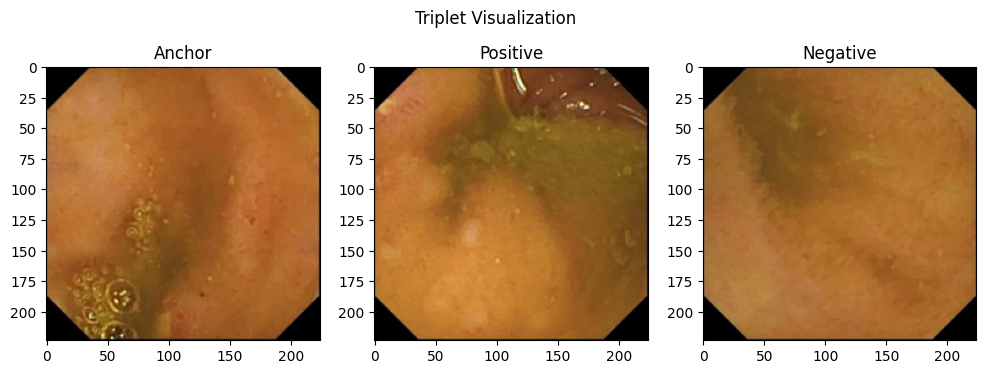

In [51]:
ulcer_folder_path = "E:/Data/TrainingAndTesting/Ulcers/Unaltered"
normal_folder_path = "E:/Data/TrainingAndTesting/NoFindings/Unaltered"

train_data, test_data = getTrainingAndTestingDatasets(1, 0.8, ulcer_folder_path, normal_folder_path)
visualize(train_data[0])

### Ulcers

In [52]:
runUlcerTests()


Findings image size: (854,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 139ms/step
Positive similarity: 0.9999997
Negative similarity 0.99999887
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.99999976
Negative similarity 0.99999964
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.99999976
Negative similarity 0.9999998
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.9999995
Negative similarity 0.9999999
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.9999997
Negative similarity 0.9999995
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.9999997
Negative similarity 0.99999964
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.9999994
Negative similarity 0.9999982
Correct 

### Polyps

In [53]:
runPolypTests()


Findings image size: (55,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 193ms/step
Positive similarity: 0.99993277
Negative similarity 0.99963164
Correct prediction!
1/1 [==============================] - 0s 43ms/step
Positive similarity: 0.9995262
Negative similarity 0.9995868
1/1 [==============================] - 0s 40ms/step
Positive similarity: 0.9999894
Negative similarity 0.9991808
Correct prediction!
1/1 [==============================] - 0s 55ms/step
Positive similarity: 0.9998589
Negative similarity 0.9996373
Correct prediction!
1/1 [==============================] - 0s 36ms/step
Positive similarity: 0.99989235
Negative similarity 0.99989146
Correct prediction!
1/1 [==============================] - 0s 42ms/step
Positive similarity: 0.99979615
Negative similarity 0.999869
1/1 [==============================] - 0s 45ms/step
Positive similarity: 0.9991984
Negative similarity 0.9997122
1/1 [=====

### Erosions

In [54]:
runErosionTests()


Findings image size: (506,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 245ms/step
Positive similarity: 0.97351015
Negative similarity 0.9535262
Correct prediction!
1/1 [==============================] - 0s 43ms/step
Positive similarity: 0.9393313
Negative similarity 0.94665813
1/1 [==============================] - 0s 44ms/step
Positive similarity: 0.9073826
Negative similarity 0.831743
Correct prediction!
1/1 [==============================] - 0s 43ms/step
Positive similarity: 0.719262
Negative similarity 0.8512379
1/1 [==============================] - 0s 32ms/step
Positive similarity: 0.9851177
Negative similarity 0.8436874
Correct prediction!
1/1 [==============================] - 0s 47ms/step
Positive similarity: 0.8948608
Negative similarity 0.9116639
1/1 [==============================] - 0s 37ms/step
Positive similarity: 0.98163736
Negative similarity 0.76622874
Correct prediction!
1/1 [======

### Erythema

In [55]:
runErythemaTests()


Findings image size: (159,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 245ms/step
Positive similarity: 0.6647302
Negative similarity 0.664832
1/1 [==============================] - 0s 48ms/step
Positive similarity: 0.28328148
Negative similarity -0.6807047
Correct prediction!
1/1 [==============================] - 0s 45ms/step
Positive similarity: 0.18374506
Negative similarity 0.3201509
1/1 [==============================] - 0s 45ms/step
Positive similarity: -0.46320346
Negative similarity 0.35930002
1/1 [==============================] - 0s 28ms/step
Positive similarity: 0.6946938
Negative similarity 0.49327955
Correct prediction!
1/1 [==============================] - 0s 48ms/step
Positive similarity: 0.40330648
Negative similarity 0.6285529
1/1 [==============================] - 0s 48ms/step
Positive similarity: 0.94946444
Negative similarity -0.02618599
Correct prediction!
1/1 [==================

## Meta Filters

In [56]:
train_with_meta_filters = True
train_with_bounding_boxes = False
train_with_segmentation_masks = False

### Visualize


Findings image size: (854,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200


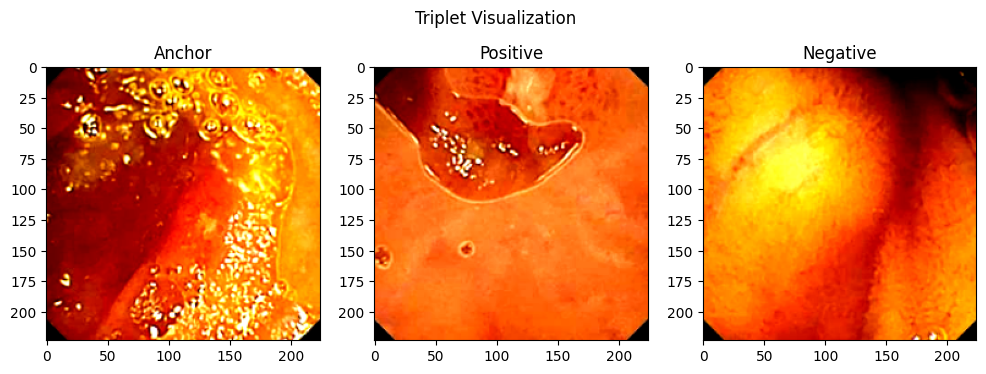

In [57]:
ulcer_folder_path = "E:/Data/TrainingAndTesting/Ulcers/Unaltered"
normal_folder_path = "E:/Data/TrainingAndTesting/NoFindings/Unaltered"

train_data, test_data = getTrainingAndTestingDatasets(10, 0.8, ulcer_folder_path, normal_folder_path)
visualize(train_data[0])

### Ulcers

In [58]:
runUlcerTests()


Findings image size: (854,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 203ms/step
Positive similarity: 0.7235656
Negative similarity 0.794356
1/1 [==============================] - 0s 44ms/step
Positive similarity: 0.7148293
Negative similarity 0.17009443
Correct prediction!
1/1 [==============================] - 0s 36ms/step
Positive similarity: 0.32097334
Negative similarity 0.78923327
1/1 [==============================] - 0s 43ms/step
Positive similarity: 0.94939935
Negative similarity 0.93874145
Correct prediction!
1/1 [==============================] - 0s 44ms/step
Positive similarity: 0.84645045
Negative similarity 0.51976025
Correct prediction!
1/1 [==============================] - 0s 30ms/step
Positive similarity: 0.3070585
Negative similarity 0.9505389
1/1 [==============================] - 0s 37ms/step
Positive similarity: 0.27220073
Negative similarity 0.67623067
1/1 [====================

### Polyps

In [59]:
runPolypTests()


Findings image size: (55,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 135ms/step
Positive similarity: -0.31242114
Negative similarity 0.3615343
1/1 [==============================] - 0s 23ms/step
Positive similarity: -0.12669952
Negative similarity 0.78064966
1/1 [==============================] - 0s 22ms/step
Positive similarity: -0.10333419
Negative similarity 0.85115206
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.8432822
Negative similarity 0.9397875
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.9308655
Negative similarity -0.5219982
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: -0.23699224
Negative similarity -0.5090307
Correct prediction!
1/1 [==============================] - 0s 21ms/step
Positive similarity: 0.98641515
Negative similarity -0.76018834
Correct prediction!
1/1 [==============

### Erosions

In [60]:
runErosionTests()


Findings image size: (506,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 153ms/step
Positive similarity: -0.70399153
Negative similarity -0.26285845
1/1 [==============================] - 0s 25ms/step
Positive similarity: -0.29245904
Negative similarity 0.12803902
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.44832563
Negative similarity 0.653188
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.14368236
Negative similarity 0.39189714
1/1 [==============================] - 0s 24ms/step
Positive similarity: -0.6919014
Negative similarity 0.8558762
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.9079244
Negative similarity 0.4646979
Correct prediction!
1/1 [==============================] - 0s 28ms/step
Positive similarity: -0.1604473
Negative similarity 0.20943108
1/1 [==============================] - 0s 22ms/step
Positive 

### Erythema

In [61]:
runErythemaTests()


Findings image size: (159,)
Normal image size: (34338,)

Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 134ms/step
Positive similarity: -0.49984616
Negative similarity -0.3761496
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.8630769
Negative similarity 0.689567
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.5687088
Negative similarity 0.7685899
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.23631723
Negative similarity -0.5866115
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.987412
Negative similarity -0.23971252
Correct prediction!
1/1 [==============================] - 0s 27ms/step
Positive similarity: -0.09390563
Negative similarity -0.29194242
Correct prediction!
1/1 [==============================] - 0s 21ms/step
Positive similarity: -0.749012
Negative similarity 0.63111836
1/1

## Bounding Boxes

In [62]:
train_with_meta_filters = False
train_with_bounding_boxes = True
train_with_segmentation_masks = False

### Visualize


Findings image size: (854,)
Normal image size: (34338,)

1/1 [==============================] - 0s 159ms/step
Training data size:  10
Testing data size:  200


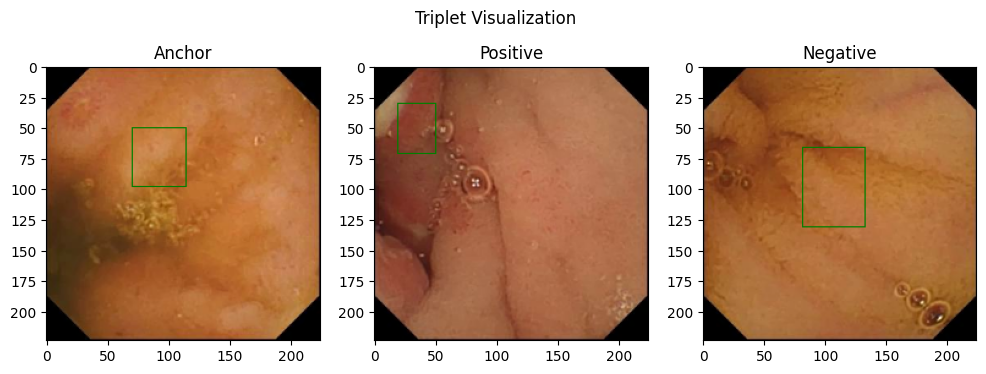

In [63]:
ulcer_folder_path = "E:/Data/TrainingAndTesting/Ulcers/Unaltered"
normal_folder_path = "E:/Data/TrainingAndTesting/NoFindings/Unaltered"

train_data, test_data = getTrainingAndTestingDatasets(10, 0.8, ulcer_folder_path, normal_folder_path)
visualize(train_data[0])

### Ulcers

In [64]:
runUlcerTests()


Findings image size: (854,)
Normal image size: (34338,)

1/1 [==============================] - 0s 67ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 134ms/step
Positive similarity: 0.99735993
Negative similarity 0.9826897
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.96674705
Negative similarity 0.9725106
1/1 [==============================] - 0s 25ms/step
Positive similarity: 0.91800606
Negative similarity 0.9360903
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.989968
Negative similarity 0.99172795
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.9615399
Negative similarity 0.9313396
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.96329606
Negative similarity 0.96350884
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.9732366
Negative similarity 0.9630

### Polyps

In [65]:
runPolypTests()


Findings image size: (55,)
Normal image size: (34338,)

1/1 [==============================] - 0s 70ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 139ms/step
Positive similarity: 0.55935466
Negative similarity -0.17681837
Correct prediction!
1/1 [==============================] - 0s 25ms/step
Positive similarity: 0.1729583
Negative similarity 0.15249799
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.4250074
Negative similarity -0.20281845
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.82640266
Negative similarity 0.30154002
Correct prediction!
1/1 [==============================] - 0s 31ms/step
Positive similarity: 0.13654391
Negative similarity -0.54607236
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: -0.6310857
Negative similarity -0.26947296
1/1 [==============================] - 0s

### Erosions

In [66]:
runErosionTests()


Findings image size: (506,)
Normal image size: (34338,)

1/1 [==============================] - 0s 68ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 144ms/step
Positive similarity: -0.09477563
Negative similarity 0.69176924
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.30359364
Negative similarity 0.028221963
Correct prediction!
1/1 [==============================] - 0s 27ms/step
Positive similarity: 0.34336656
Negative similarity 0.12493904
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: -0.09971351
Negative similarity 0.101530045
1/1 [==============================] - 0s 27ms/step
Positive similarity: 0.028198682
Negative similarity 0.26478994
1/1 [==============================] - 0s 30ms/step
Positive similarity: -0.76303065
Negative similarity -0.7091873
1/1 [==============================] - 0s 25ms/step
Positive similarity: 0.019894227
Negative si

### Erythema

In [67]:
runErythemaTests()


Findings image size: (159,)
Normal image size: (34338,)

1/1 [==============================] - 0s 68ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 141ms/step
Positive similarity: 0.80147135
Negative similarity -0.7457963
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: -0.06262722
Negative similarity -0.00957541
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.38003916
Negative similarity 0.06392508
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: -0.61102355
Negative similarity 0.17452912
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.32842517
Negative similarity 0.33779067
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.0055358447
Negative similarity -0.346326
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.279

## Segmentation Masks

In [68]:
train_with_meta_filters = False
train_with_bounding_boxes = False
train_with_segmentation_masks = True

### Visualize


Findings image size: (854,)
Normal image size: (34338,)

1/1 [==============================] - 0s 267ms/step
Training data size:  10
Testing data size:  200


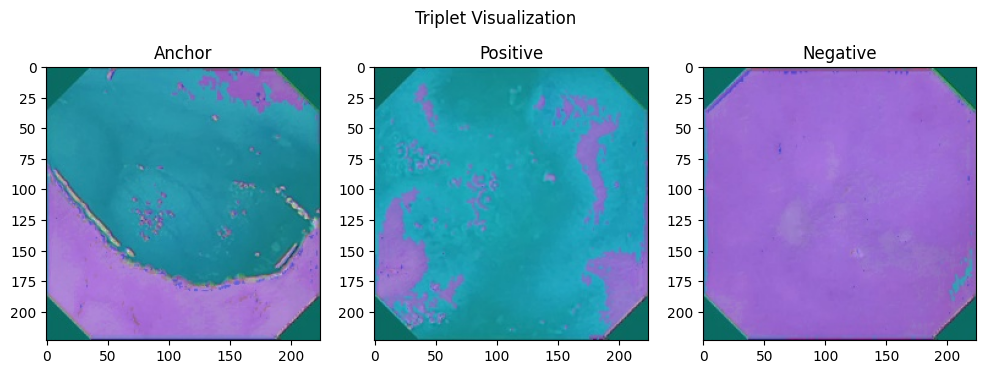

In [69]:
ulcer_folder_path = "E:/Data/TrainingAndTesting/Ulcers/Unaltered"
normal_folder_path = "E:/Data/TrainingAndTesting/NoFindings/Unaltered"

train_data, test_data = getTrainingAndTestingDatasets(10, 0.8, ulcer_folder_path, normal_folder_path)
visualize(train_data[0])

### Ulcers

In [70]:
runUlcerTests()


Findings image size: (854,)
Normal image size: (34338,)

1/1 [==============================] - 0s 259ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 138ms/step
Positive similarity: 0.7760841
Negative similarity 0.99307644
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.95200914
Negative similarity 0.94573694
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.98079693
Negative similarity 0.9771264
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.85405076
Negative similarity 0.94533885
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.8496752
Negative similarity 0.95610726
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.9757938
Negative similarity 0.9882661
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.8418596
Negative similarity 0.9

### Polyps

In [71]:
runPolypTests()


Findings image size: (55,)
Normal image size: (34338,)

1/1 [==============================] - 0s 272ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 136ms/step
Positive similarity: 0.7005997
Negative similarity -0.7616842
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.24353094
Negative similarity 0.37243965
1/1 [==============================] - 0s 25ms/step
Positive similarity: 0.7857233
Negative similarity 0.3394592
Correct prediction!
1/1 [==============================] - 0s 25ms/step
Positive similarity: -0.69633543
Negative similarity -0.8181579
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.6336718
Negative similarity 0.08150532
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: -0.37633693
Negative similarity 0.47919393
1/1 [==============================] - 0s 24ms/step
Positive sim

### Erosions

In [72]:
runErosionTests()


Findings image size: (506,)
Normal image size: (34338,)

1/1 [==============================] - 0s 264ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 142ms/step
Positive similarity: -0.7711711
Negative similarity -0.78941745
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: -0.7851191
Negative similarity 0.8651357
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.60597
Negative similarity 0.3444831
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.19719099
Negative similarity -0.1557423
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.19963214
Negative similarity 0.008921262
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: -0.12516484
Negative similarity -0.39050466
Correct prediction!
1/1 [==============================] - 0s 

### Erythema

In [73]:
runErythemaTests()


Findings image size: (159,)
Normal image size: (34338,)

1/1 [==============================] - 0s 262ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 151ms/step
Positive similarity: 0.5953517
Negative similarity 0.29139897
Correct prediction!
1/1 [==============================] - 0s 25ms/step
Positive similarity: 0.40886104
Negative similarity -0.0518275
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.99056196
Negative similarity 0.44063312
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.21115986
Negative similarity -0.34827733
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.8798531
Negative similarity 0.072269335
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: -0.47821397
Negative similarity 0.13308153
1/1 [==============================] - 0

## All Filters

In [74]:
train_with_meta_filters = True
train_with_bounding_boxes = True
train_with_segmentation_masks = True

### Visualize


Findings image size: (854,)
Normal image size: (34338,)

1/1 [==============================] - 0s 267ms/step
Training data size:  10
Testing data size:  200


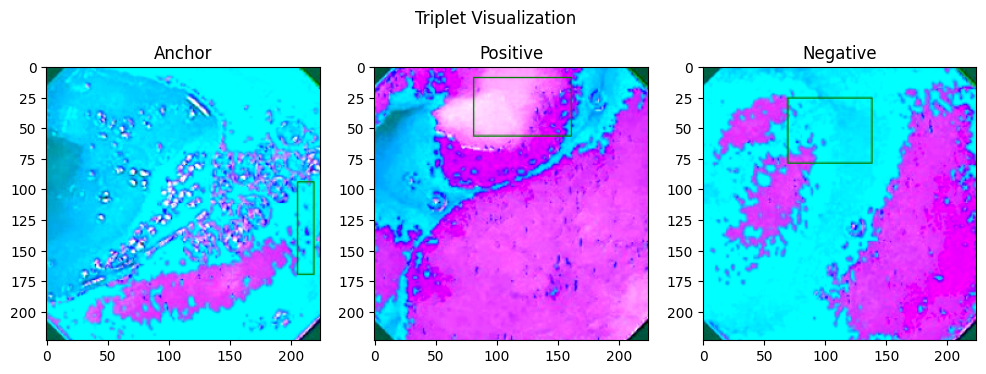

In [75]:
ulcer_folder_path = "E:/Data/TrainingAndTesting/Ulcers/Unaltered"
normal_folder_path = "E:/Data/TrainingAndTesting/NoFindings/Unaltered"

train_data, test_data = getTrainingAndTestingDatasets(10, 0.8, ulcer_folder_path, normal_folder_path)
visualize(train_data[0])

### Ulcers

In [76]:
runUlcerTests()


Findings image size: (854,)
Normal image size: (34338,)

1/1 [==============================] - 0s 270ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 141ms/step
Positive similarity: 0.88051957
Negative similarity 0.8551134
Correct prediction!
1/1 [==============================] - 0s 26ms/step
Positive similarity: 0.90666586
Negative similarity 0.967134
1/1 [==============================] - 0s 26ms/step
Positive similarity: 0.92017925
Negative similarity 0.95096856
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.936136
Negative similarity 0.97109467
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.98599213
Negative similarity 0.97989494
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.9158288
Negative similarity 0.7563479
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.9986968
Negat

### Polyps

In [77]:
runPolypTests()


Findings image size: (55,)
Normal image size: (34338,)

1/1 [==============================] - 0s 262ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 145ms/step
Positive similarity: 0.6502764
Negative similarity -0.5900837
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: -0.68215513
Negative similarity 0.5730111
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.75291574
Negative similarity 0.8600217
1/1 [==============================] - 0s 27ms/step
Positive similarity: 0.5450714
Negative similarity -0.75107694
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.15602627
Negative similarity 0.3344199
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.6395203
Negative similarity -0.19531333
Correct prediction!
1/1 [==============================] - 0s 25ms/step
Positive similarity: 0.9849206
Ne

### Erosions

In [78]:
runErosionTests()


Findings image size: (506,)
Normal image size: (34338,)

1/1 [==============================] - 0s 262ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 132ms/step
Positive similarity: -0.10235271
Negative similarity 0.008029401
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.48137045
Negative similarity -0.45375904
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.9712619
Negative similarity -0.010317719
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: -0.50149155
Negative similarity -0.7065631
Correct prediction!
1/1 [==============================] - 0s 24ms/step
Positive similarity: 0.9040386
Negative similarity 0.7336504
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.84053963
Negative similarity 0.8363613
Correct prediction!
1/1 [==============================] - 

### Erythemas

In [79]:
runErythemaTests()


Findings image size: (159,)
Normal image size: (34338,)

1/1 [==============================] - 0s 260ms/step
Training data size:  10
Testing data size:  200
epoch: 1
1/1 [==============================] - 0s 137ms/step
Positive similarity: 0.5881545
Negative similarity -0.4279308
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.91966
Negative similarity -0.8715643
Correct prediction!
1/1 [==============================] - 0s 23ms/step
Positive similarity: 0.95530576
Negative similarity 0.88245195
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: -0.95297146
Negative similarity -0.6839991
1/1 [==============================] - 0s 22ms/step
Positive similarity: 0.9292822
Negative similarity 0.5473811
Correct prediction!
1/1 [==============================] - 0s 22ms/step
Positive similarity: -0.5762749
Negative similarity -0.6043009
Correct prediction!
1/1 [==============================] - 0s 23ms